#Credit Risk Analysis with Machine Learning
####Predicting the risk of client default using XGBoost, LightGBM and CatBoost

**Credit risk** is associated with the possibility of a client failing to meet contractual obligations, such as mortgages, credit card debts, and other types of loans.

Minimizing the risk of default is a major concern for financial institutions. For this reason, commercial and investment banks, venture capital funds, asset management companies and insurance firms, to name a few, are increasingly relying on technology to predict which clients are more prone to not honoring their debts.

**Machine Learning model** bold text bold texthave been helping these companies to improve the accuracy of their credit risk analysis, providing a scientific method to identify potential debtors in advance.

In this article, we will build a model to predict the risk of client default for Nubank, a prominent Brazilian Fintech.

##About the Data
Nubank is a Brazilian digital bank and one of the largest Fintechs in Latin America. It is known to be a data-driven company, taking advantage of technology to make decisions and improve services.

Some private information were hashed to keep the data anonymous.

Let's import the libraries we'll need for the analysis and take a first look at our data frame.

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.5 MB/s eta 0:00:00


In [4]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

In [5]:
# set default matplotlib parameters
COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [8]:
# import data set and create a data frame
df_credit = pd.read_csv('http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0')

In [11]:
# show first 5 rows
df_credit.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


Data Analysis

In [12]:
# data frame shape
print('Number of rows: ', df_credit.shape[0])
print('Number of columns: ', df_credit.shape[1])

Number of rows:  45000
Number of columns:  43


We are working with a data set containing 43 features for 45,000 clients. target_default is a True/False feature and is the target variable we are trying to predict. We'll explore all features searching for outliers, treating possible missing values, and making other necessary adjustments to improve the overall quality of the model.

Let's examine the structure of the data set.

In [13]:
# data frame summary
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

We can see that some features have missing values. Let's take a closer look at them

In [14]:

# percentage of missing values per feature
print((df_credit.isnull().sum() * 100 / df_credit.shape[0]).sort_values(ascending=False))

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

First of all, note that target_default has missing values. As this is our target variable, we don't have a lot of options here. So, we'll eliminate all entries where target_default is null.

In [15]:
df_credit.dropna(subset=['target_default'], inplace=True)

Observe that target_fraud has almost all its entries missing. As this feature is not crucial for the project, we are dropping it.

Other variables also have a high rate of missing values, but we are not dealing with them by now.

In [16]:
# drop the column "target_fraud"
df_credit.drop('target_fraud', axis=1, inplace=True)

Now, let's examine the number of unique values for each feature.

In [17]:
# number of unique observations per column
df_credit.nunique().sort_values()

,0
channel,1
external_data_provider_credit_checks_last_2_year,1
last_borrowed_in_months,2
target_default,2
facebook_profile,2
external_data_provider_credit_checks_last_year,2
external_data_provider_credit_checks_last_month,4
real_state,5
n_defaulted_loans,5
email,6


The features channel and external_data_provider_credit_checks_last_2_year have only one value. As that won't be useful for the model, we can drop these two columns

In [18]:
# drop the columns "channel" and "external_data_provider_credit_checks_last_2_year"
df_credit.drop(labels=['channel', 'external_data_provider_credit_checks_last_2_year'], axis=1, inplace=True)

Moving on with the cleaning process, to keep the data set as adequate as possible we'll remove some other columns that are not adding value to the model. Some features, as score_1 and score_2, are filled with hashed values. However, we are keeping these variables as they might be useful to our model.

In [19]:
df_credit.drop(labels=['email', 'reason', 'zip', 'job_name', 'external_data_provider_first_name', 'lat_lon',
                       'shipping_zip_code', 'user_agent', 'profile_tags', 'marketing_channel',
                       'profile_phone_number', 'application_time_applied', 'ids'], axis=1, inplace=True)

Ok, now we are working with a leaner data set. Before dealing with the missing values, let's examine if there are outliers in the data set. We'll start by taking a look at some statistical details of the numerical features.

In [20]:
# show descriptive statistics
df_credit.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
count,41741.000000,41741.000000,41741.000000,41741.000000,41741.000000,14133.000000,14133.000000,28632.000000,4.174100e+04,17276.000000,41606.000000,41729.000000,41741.000000,30818.000000,41741.000000,41741.000000,27720.000000,39656.000000,41741.000000,41741.0
mean,346.459836,100.006820,0.499416,99.919399,0.294451,13328.104095,40.588410,33877.220453,7.108012e+04,35.192174,0.076696,0.004625,10.639108,11.023882,247.748545,1.504396,0.504185,12.731188,500.491771,inf
std,110.102271,3.183821,0.288085,10.022703,0.101561,7918.698433,9.437936,36141.985884,5.225978e+04,21.629577,0.274820,0.080157,4.588175,4.596036,146.326172,1.114207,0.499992,125.711218,287.993121,NaN
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,403.0
25%,270.000000,97.862546,0.251595,93.182517,0.220000,7210.280000,36.000000,9975.000000,4.401958e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,11.000000,252.000000,50910.0
50%,340.000000,100.017950,0.500174,99.977774,0.290000,12011.050000,36.000000,25213.000000,6.004409e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,27.000000,502.000000,101623.0
75%,420.000000,102.143100,0.747630,106.630991,0.360000,18030.160000,36.000000,46492.500000,8.503289e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,43.000000,747.000000,151248.0
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,inf


In [21]:
# count of "inf" values in "reported_income"
np.isinf(df_credit['reported_income']).sum()

66

In [22]:
# count of values = -999 in "external_data_provider_email_seen_before"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'].value_counts()


,count
external_data_provider_email_seen_before,
-999.0,591


First of all, when examining the statistics above, we noticed that reported_income has 66 values displayed as "inf". Additionally, we have 591 values of external_data_provider_email_seen_before displayed as -999. We'll replace these values with NaN, so we can plot histograms to visualize the values' distributions.

In [23]:
# replace "inf" values with "nan"
df_credit['reported_income'] = df_credit['reported_income'].replace(np.inf, np.nan)

# replace "-999" values with "nan"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'] = np.nan


A new data frame, containing numerical features of interest, will be created. Plotting a histogram for these features will helps us examine their distribution.

In [24]:
# data frame containing numerical features
df_credit_numerical = df_credit[['score_3', 'risk_rate', 'last_amount_borrowed',
                                 'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since',
                                 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues',
                                 'external_data_provider_email_seen_before']]

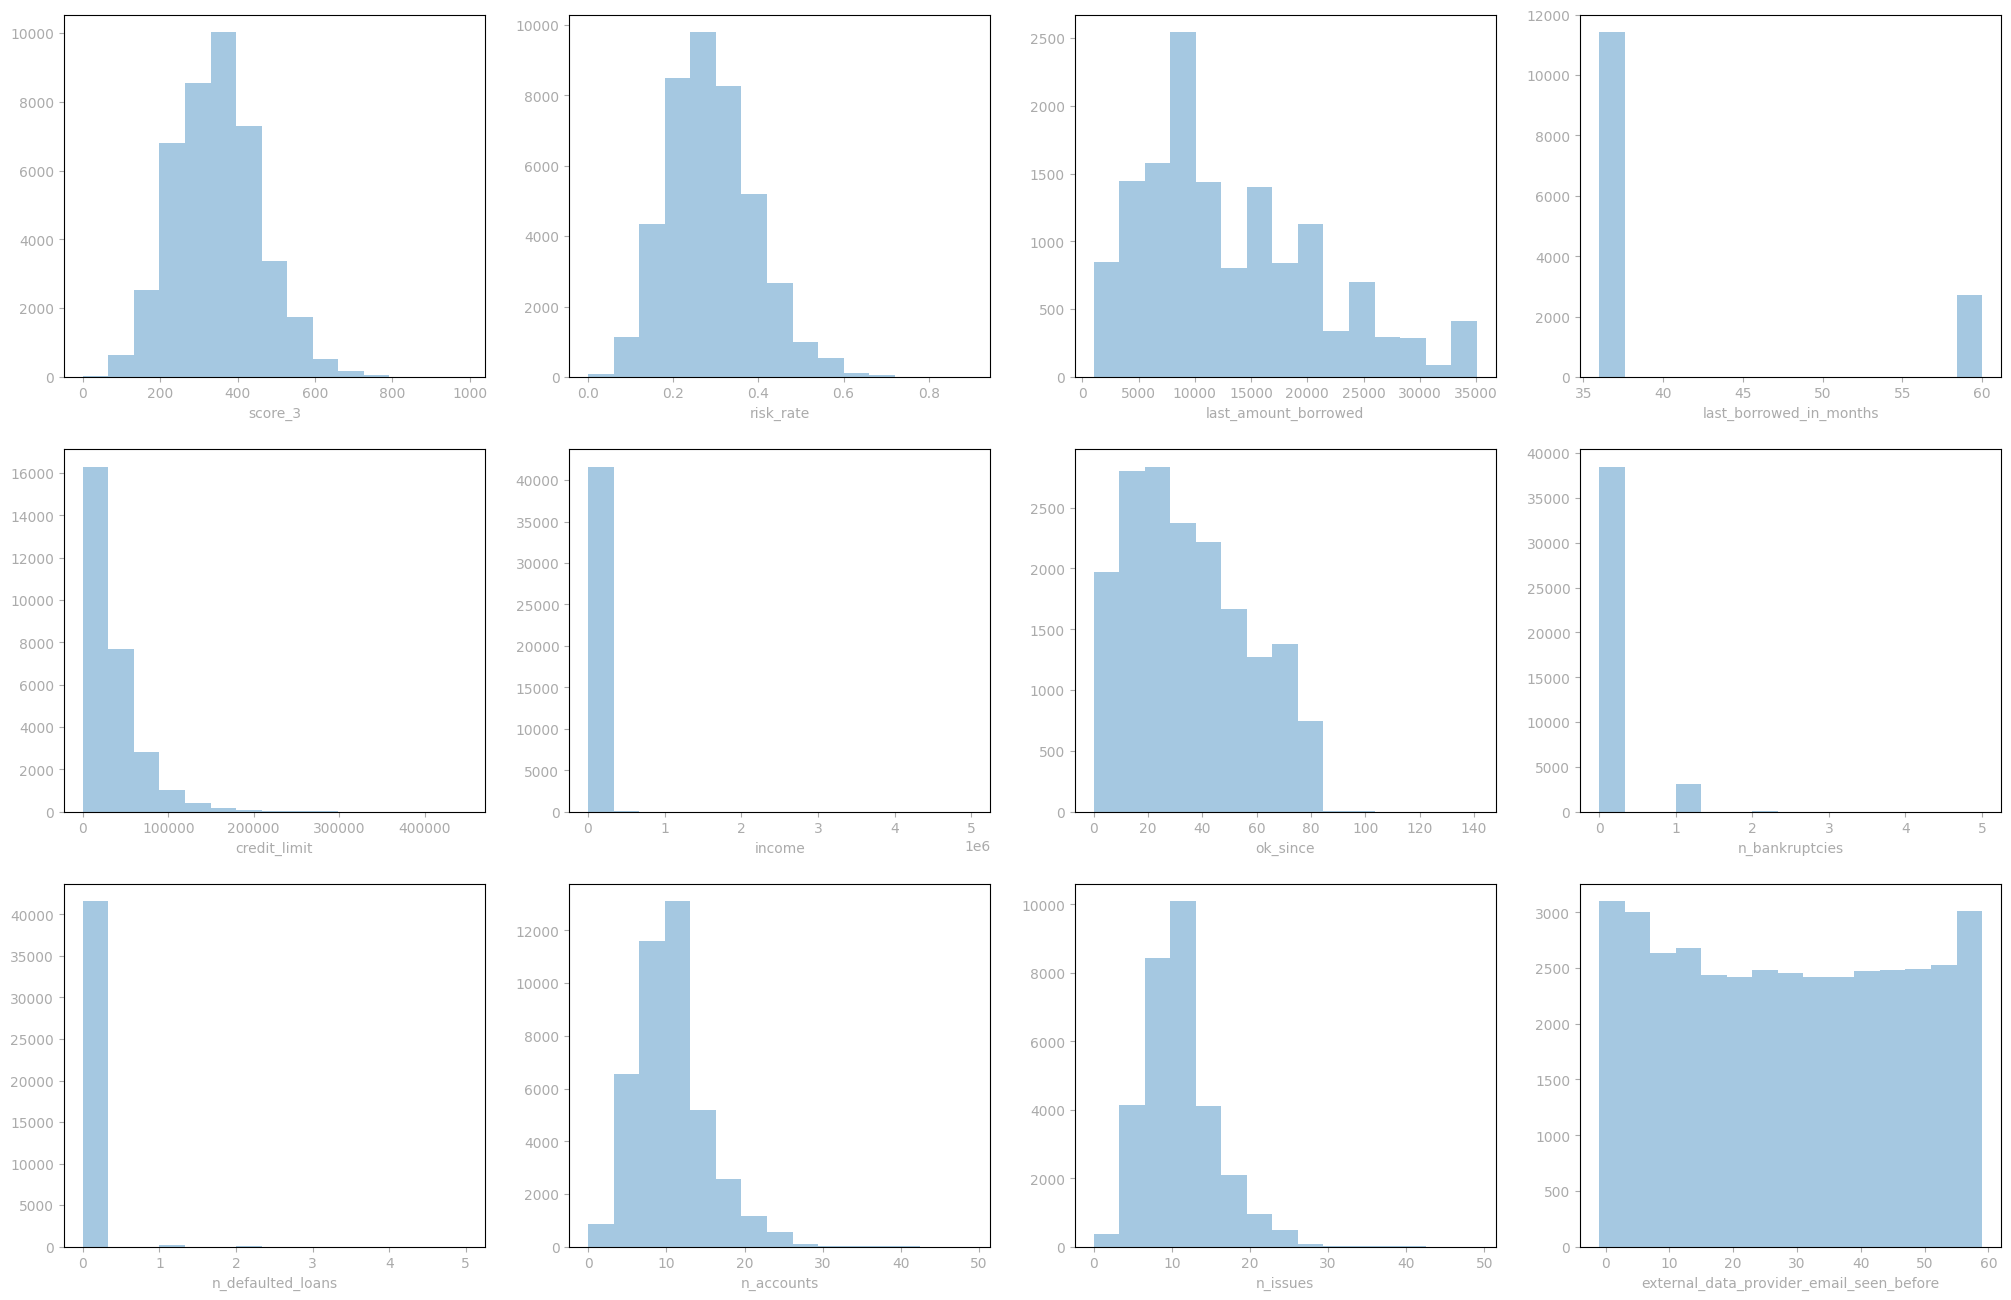

In [25]:
# plot a histogram for each of the features above

nrows = 3
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 16))

r = 0
c = 0

for i in df_credit_numerical:
  sns.distplot(df_credit_numerical[i], bins=15,kde=False, ax=ax[r][c])
  if c == ncols - 1:
    r += 1
    c = 0
  else:
    c += 1

plt.show()

All these features above have missing values that need to be treated. As we can see, they have skewed distribution, which is an indication that we should fill the missing values with the median value for each feature.

It's time to deal with the missing values from the remaining 32 columns. We are filling these values according to the particularities of each feature, as below:

Categorical variables will be filled with the most recurrent value.
Numerical variables will be filled with their median values.
In the specific cases of last_amount_borrowed, last_borrowed_in_months and n_issues we'll fill the missing values with zero, as it is reasonable to believe that not every client would have values assigned to these variables.

In [26]:
df_credit_num = df_credit.select_dtypes(exclude='object').columns
df_credit_cat = df_credit.select_dtypes(include='object').columns

# fill missing values for "last_amount_borrowed", "last_borrowed_in_months" and "n_issues"
df_credit['last_amount_borrowed'].fillna(value=0, inplace=True)
df_credit['last_borrowed_in_months'].fillna(value=0, inplace=True)
df_credit['n_issues'].fillna(value=0, inplace=True)

# fill missing values for numerical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_credit.loc[:, df_credit_num])
df_credit.loc[:, df_credit_num] = imputer.transform(df_credit.loc[:, df_credit_num])

# fill missing values for categorical variables
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_credit.loc[:, df_credit_cat])
df_credit.loc[:, df_credit_cat] = imputer.transform(df_credit.loc[:, df_credit_cat])

In [27]:

df_credit.isnull().sum()

,0
target_default,0
score_1,0
score_2,0
score_3,0
score_4,0
score_5,0
score_6,0
risk_rate,0
last_amount_borrowed,0
last_borrowed_in_months,0


After handling the missing values, case by case, we now have a data set free of null values.

We'll now preprocess the data, converting the categorical features into numerical values. LabelEncoder will be used for the binary variables while get_dummies will be used for the other categorical variables.

In [28]:
bin_var = df_credit.nunique()[df_credit.nunique() == 2].keys().tolist()
num_var = [col for col in df_credit.select_dtypes(['int', 'float']).columns.tolist() if col not in bin_var]
cat_var = [col for col in df_credit.select_dtypes(['object']).columns.tolist() if col not in bin_var]

df_credit_encoded = df_credit.copy()

# label encoding for the binary variables
le = LabelEncoder()
for col in bin_var:
  df_credit_encoded[col] = le.fit_transform(df_credit_encoded[col])

# encoding with get_dummies for the categorical variables
df_credit_encoded = pd.get_dummies(df_credit_encoded, columns=cat_var)

df_credit_encoded.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,...,shipping_state_BR-PE,shipping_state_BR-PR,shipping_state_BR-RN,shipping_state_BR-RO,shipping_state_BR-RR,shipping_state_BR-RS,shipping_state_BR-SC,shipping_state_BR-SE,shipping_state_BR-SP,shipping_state_BR-TO
0,0,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,65014.12,...,False,False,False,False,False,False,False,False,False,False
1,0,370.0,97.062615,0.942655,92.002546,0.24,0.00,0.0,39726.0,100018.91,...,False,False,False,False,False,True,False,False,False,False
2,1,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,25213.0,65023.65,...,False,False,False,False,True,False,False,False,False,False
3,0,510.0,101.599485,0.987673,94.902491,0.32,0.00,0.0,54591.0,68830.01,...,False,False,True,False,False,False,False,False,False,False
4,0,500.0,98.474289,0.532539,118.126207,0.18,0.00,0.0,25213.0,60011.29,...,False,False,False,False,False,False,False,False,False,False


After encoding the categorical variables, let's start working on the machine learning models.

##Machine Learning Models
We are experimenting with the following 3 boosting algorithms to determine which one yields better results:

#####1.XGBoost
#####2.LightGBM
#####3.CatBoost
Before starting with the models, let's split the data into training and test sets.

In [29]:
# feature matrix
X = df_credit_encoded.drop('target_default', axis=1)

# target vector
y = df_credit_encoded['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

Now, as we are dealing with an unbalanced data set, we'll standardize and resample the training set, with StandardScaler and RandomUnderSampler, respectively.

In [33]:
# standardize numerical variables
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# resample
rus = RandomUnderSampler()
# Use fit_resample instead of fit_sample
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

######We're all set up to start evaluating the models. It's worth mentioning that we should consider Precision, Recall and F1 Score as evaluation metrics, for the following reasons
######Precision will give us the proportion of positive identifications that were indeed correct.
######Recall will determine the proportion of real positives that were correctly identified
######F1 Score is a metric that is useful when we need to seek a balance between precision and recall
Since our objective is to minimize company loss, predicting the risk of client default, a good recall rate is desirable because we want to identify the maximum amount of clients that are indeed prone to stop paying their debts, thus, we are pursuing a small number of False Negatives.

Additionally, we also seek to minimize the number of False Positives because we don't want clients to be mistakenly identified as defaulters. Therefore, a good precision rate is also desirable.

However, there is always a tradeoff between precision and recall. For this article, we chose to give more emphasis to recall, using it as our evaluation metric.

We'll use Cross-Validation to get better results. Instead of simply splitting the data into a train and test set, the cross_validate method splits our training data into k number of Folds, making better use of the data. In our case, we'll perform 5-fold cross-validation, as we let the default k value.

In [34]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.

    # Returns
        float, mean value of the cross-validation scores.
    """

    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')

    return scores.mean()

In [35]:
#evaluate the models
xgb = XGBClassifier()
lgb = LGBMClassifier()
cb = CatBoostClassifier()

model = []
recall = []

for clf in (xgb, lgb, cb):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

Streaming output truncated to the last 5000 lines.
4:	learn: 0.6787486	total: 77.8ms	remaining: 15.5s
5:	learn: 0.6765591	total: 83.6ms	remaining: 13.9s
6:	learn: 0.6742033	total: 89.8ms	remaining: 12.7s
7:	learn: 0.6719384	total: 95.8ms	remaining: 11.9s
8:	learn: 0.6700860	total: 105ms	remaining: 11.5s
9:	learn: 0.6679039	total: 111ms	remaining: 11s
10:	learn: 0.6660985	total: 117ms	remaining: 10.5s
11:	learn: 0.6643779	total: 122ms	remaining: 10.1s
12:	learn: 0.6626676	total: 128ms	remaining: 9.72s
13:	learn: 0.6609047	total: 134ms	remaining: 9.44s
14:	learn: 0.6592967	total: 140ms	remaining: 9.2s
15:	learn: 0.6577543	total: 146ms	remaining: 8.99s
16:	learn: 0.6565128	total: 153ms	remaining: 8.82s
17:	learn: 0.6549214	total: 159ms	remaining: 8.66s
18:	learn: 0.6534140	total: 165ms	remaining: 8.5s
19:	learn: 0.6524046	total: 170ms	remaining: 8.35s
20:	learn: 0.6512091	total: 176ms	remaining: 8.22s
21:	learn: 0.6500280	total: 183ms	remaining: 8.13s
22:	learn: 0.6490293	total: 190ms	rem

,Recall
XGBClassifier,0.639516
LGBMClassifier,0.651322
CatBoostClassifier,0.663132


After tuning some hyperparameters, all three models displayed betters results. It is worth mentioning that XGBoost presented a great score increase, while LightGBM and CatBoost saw a meager improvement.

Now, we can check how these models perform on the test set. To help us visualize the results, we are plotting a confusion matrix.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8771
           1       0.16      1.00      0.28      1665

    accuracy                           0.16     10436
   macro avg       0.08      0.50      0.14     10436
weighted avg       0.03      0.16      0.04     10436



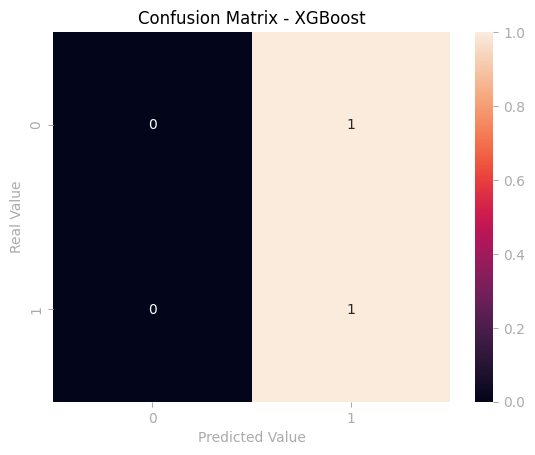

In [36]:
# final XGBoost model
xgb = XGBClassifier(max_depth=3, learning_rate=0.0001, n_estimators=50, gamma=1, min_child_weight=6)
xgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Info] Number of positive: 4996, number of negative: 4996
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 9992, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

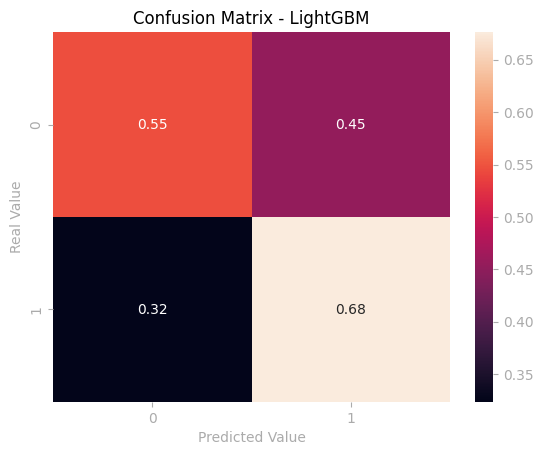

In [37]:
# final LightGBM model
lgb = LGBMClassifier(num_leaves=70, max_depth=5, learning_rate=0.01, min_data_in_leaf=400)
lgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_lgb = scaler.transform(X_test)
y_pred_lgb = lgb.predict(X_test_lgb)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

           0       0.88      0.78      0.82      8771
           1       0.27      0.44      0.33      1665

    accuracy                           0.72     10436
   macro avg       0.57      0.61      0.58     10436
weighted avg       0.78      0.72      0.75     10436



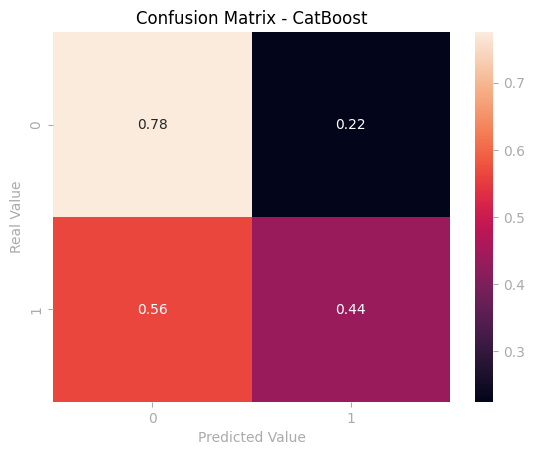

In [38]:
cb = CatBoostClassifier(learning_rate=0.03, depth=6, l2_leaf_reg=5, logging_level='Silent')
cb.fit(X_train_rus, y_train_rus)

# prediction
X_test_cb = scaler.transform(X_test)
y_pred_cb = cb.predict(X_test_cb)

# classification report
print(classification_report(y_test, y_pred_cb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_cb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - CatBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

##Conclusion
The main objective of this article was to build a machine learning algorithm that would be able to identify potential defaulters and therefore reduce company loss. The best model possible would be the one that could minimize false negatives, identifying all defaulters among the client base, while also minimizing false positives, preventing clients to be wrongly classified as defaulters.

Meeting these requirements can be quite tricky as there is a tradeoff between precision and recall, meaning that increasing the value of one of these metrics often decreases the value of the other. Considering the importance of minimizing company loss, we decided to give more emphasis on reducing false positives, searching for the best hyperparameters that could increase the recall rate.

Among the three Gradient Boosting Algorithms tested, XGBoost yielded the best results, with a recall rate of 81%, although it delivered an undesired 56% of false positives. On the other hand, LightGBM and CatBoost delivered a better count of false positives, with 38% and 33% respectively, but their false negatives were substantially higher than that of XGBoost, resulting in a weaker recall rate.

This article presents a classic evaluation metrics dilemma. In this case, it would be up to the company's decision-makers to analyze the big picture, with the aid of the machine learning algorithms, and decide the best plan to follow. Of course, in a future article, we can test a different approach to achieve a more desirable result, such as taking advantage of deep learning models.